In [2]:
import numpy as np
from scipy import linalg

def gram_schmidt_columns(X):
    """
    The gram schmidt transform will provide orthogonal vectors. If the vectors we provide exist in a planar manifold
    the resulting vectors should remain in the manifold. TBC!!!
    """
    Q, R = np.linalg.qr(X)
    return Q

def rotate_in_subspace(V,v = None,angleinvert=False):
    """
    creates a rotation matrix that rotates between two vectors
    defined as the columns of V,
    such that the rotation occurs in a plane defined by the two vectors
    (as two vectors is insufficient to describe an arbitrary rotation in n-dimensions)
    """

    #this used to be a single vector, but to generate a general matrix result:
    if v is None:
        v = np.eye(len(V)) 
    
    #the two vectors now with length 1
    Vnormalised = V*np.repeat(1./np.sqrt(np.sum(V**2,0))[None,:],len(V),axis=0)

    #this is the same span but with orthonormal vectors (each column is one vector)
    #annoyingly this can swap the direction of a rotation...
    G = gram_schmidt_columns(V)

    #We find the matrix that projects from the space to the hyperplane subspace
    P = np.dot(G,G.T)

    #projected onto the plane
    vprime = np.dot(P,v)

    #the difference between v and vprime
    deltav = vprime-v

    #coord in basis
    coords = np.dot(G.T,vprime)

    #angle of the rotation
    ang = np.arccos(np.dot(Vnormalised[:,0],Vnormalised[:,1]))
    if angleinvert:
        ang = -ang

    #the rotation matrix in the 2d plane
    R = np.array([[np.cos(ang),-np.sin(ang)],[np.sin(ang),np.cos(ang)]])

    #new coordinates on the plane
    newcoords = np.dot(R,coords)

    #reprojected back to the original basis
    vprimerotated =np.dot(G,newcoords)

    #translated back from the plane
    vrotated = vprimerotated-deltav    
    return vrotated

def adjusted_rotate_in_subspace(V,v=None):
    """
    creates a rotation matrix that rotates between two vectors
    defined as the columns of V,
    such that the rotation occurs in a plane defined by the two vectors
    (as two vectors is insufficient to describe an arbitrary rotation in n-dimensions)
    
    Temporary fix - there's bound to be better!
    the problem is when the gram schmidt orthonormal basis is created, the direction of rotation can be swapped.
    as there's two choices, I simply find out whether we've got the right one...
    """
    
    #we feed in the first vector in...
    new = rotate_in_subspace(V,V[:,0])
    new/=np.sqrt(np.sum(new**2))
    #we expect the result to be the second vector...
    targ=V[:,1]/np.sqrt(np.sum(V[:,1]**2))
    
    #we've normalised them both: They should be equal
    #if they're not...
    if np.sum((new-targ)**2)>0.01: #we need to swap the order of the vectors!
        #print "Flipped angle"
        return rotate_in_subspace(V,v,angleinvert=True)
    else:
        return rotate_in_subspace(V,v)

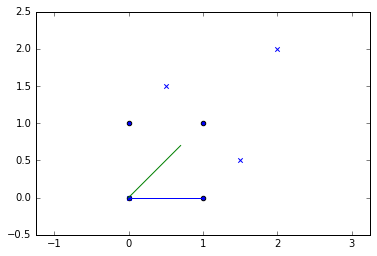

In [3]:
np.set_printoptions(suppress=True,precision=2)
v1 = np.array([1,0])
v2 = np.array([0.7,0.7])
M = adjusted_rotate_in_subspace(np.array([v1,v2]).T)
S = np.array([[2,0],[0,1]])
M = np.dot(M,np.dot(S,M.transpose()))
import matplotlib.pyplot as plt
%matplotlib inline
v = np.array([[0,0],[1,0],[1,1],[0,1]]).T
vprime = np.dot(M,v)
plt.scatter(v[0,:],v[1,:])
plt.scatter(vprime[0,:],vprime[1,:],marker='x')
plt.axis('equal')
plt.plot([0,v1[0]],[0,v1[1]])
plt.plot([0,v2[0]],[0,v2[1]])

### Test

In [51]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib.patches import Ellipse

def plotcov(C,color='blue',lw=3):
    evals, evecs = np.linalg.eig(C)
    samps = np.random.multivariate_normal(np.zeros(2),C,500)
    ax.scatter(samps[:,0],samps[:,1],marker='.',alpha=0.3)
    ang = np.rad2deg(np.arctan2(evecs[1,0],evecs[0,0]))
    ax.add_artist(Ellipse(xy=[0,0], width=4*np.sqrt(evals[0]), height=4*np.sqrt(evals[1]), angle=ang, lw=lw, ec=color, fc='none'))


C = np.array([[3,1,0,3],[1,3,1,2],[0,1,5,1],[3,2,1,8]])
C = np.array([[3,-1],[-1,3]])
D = np.array([[2.5,3],[3,5]])

Ce,Cv = np.linalg.eig(np.linalg.inv(C))
Csqrt = np.dot(Cv,np.diag(Ce**.5))
Cnew = np.dot(Csqrt.transpose(),np.dot(C,Csqrt))
Dnew = np.dot(Csqrt.transpose(),np.dot(D,Csqrt))
print C
print Cnew
print D
print Dnew

[[ 3 -1]
 [-1  3]]
[[ 1.  0.]
 [-0.  1.]]
[[ 2.5  3. ]
 [ 3.   5. ]]
[[ 3.38  0.44]
 [ 0.44  0.19]]


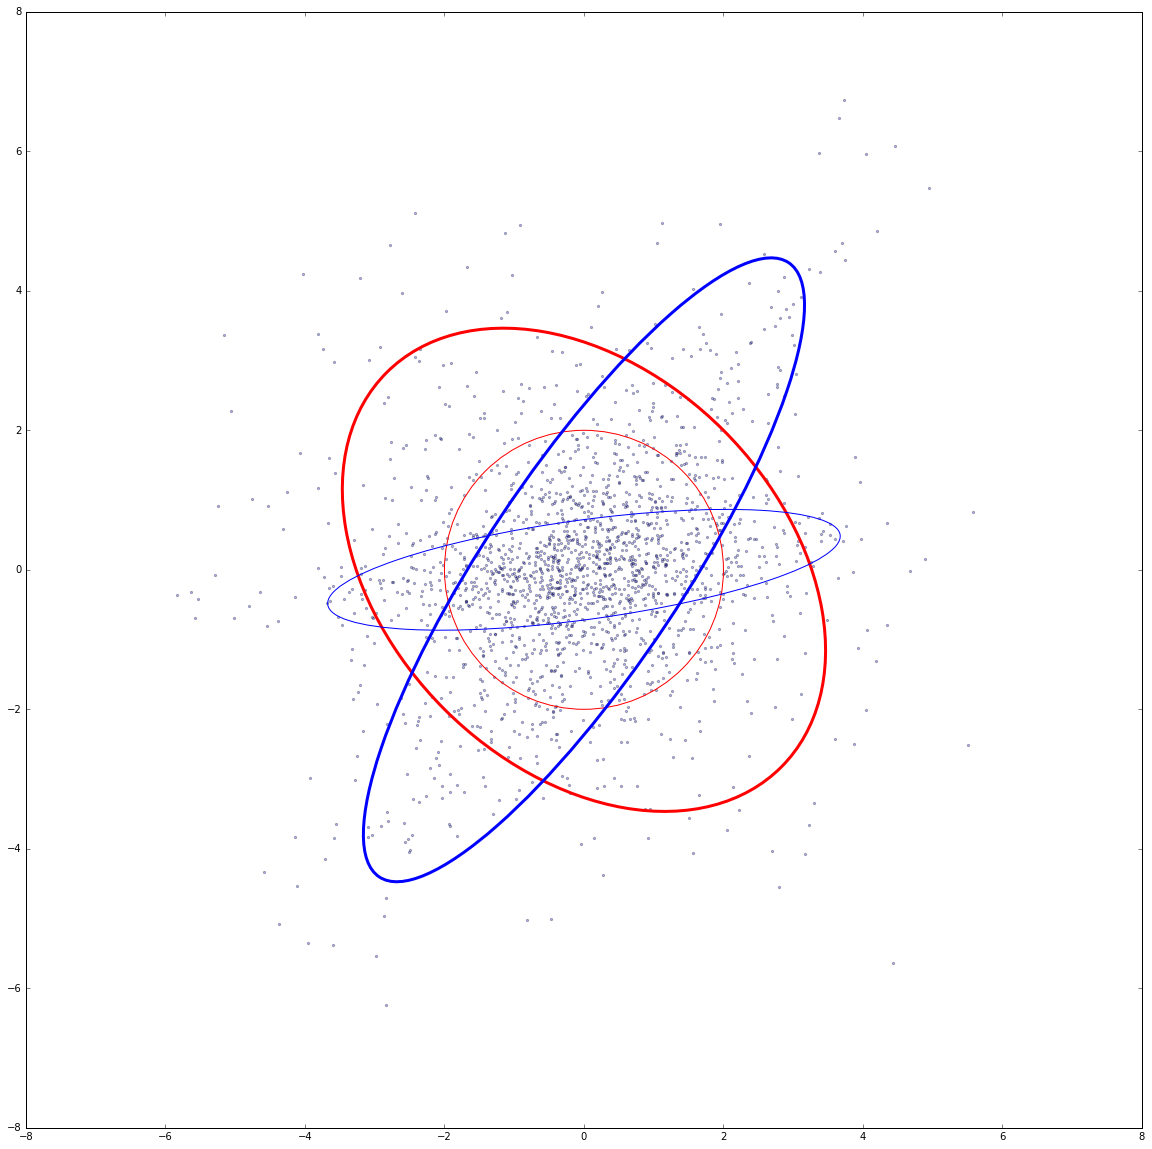

In [52]:
fig = plt.figure(0,figsize=[20,20])
ax = fig.add_subplot(111, aspect='equal')

plotcov(Cnew,'red',lw=1)
plotcov(C,'red')
plotcov(Dnew,'blue',lw=1)
plotcov(D,'blue')

TypeError: ufunc 'arctan2' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

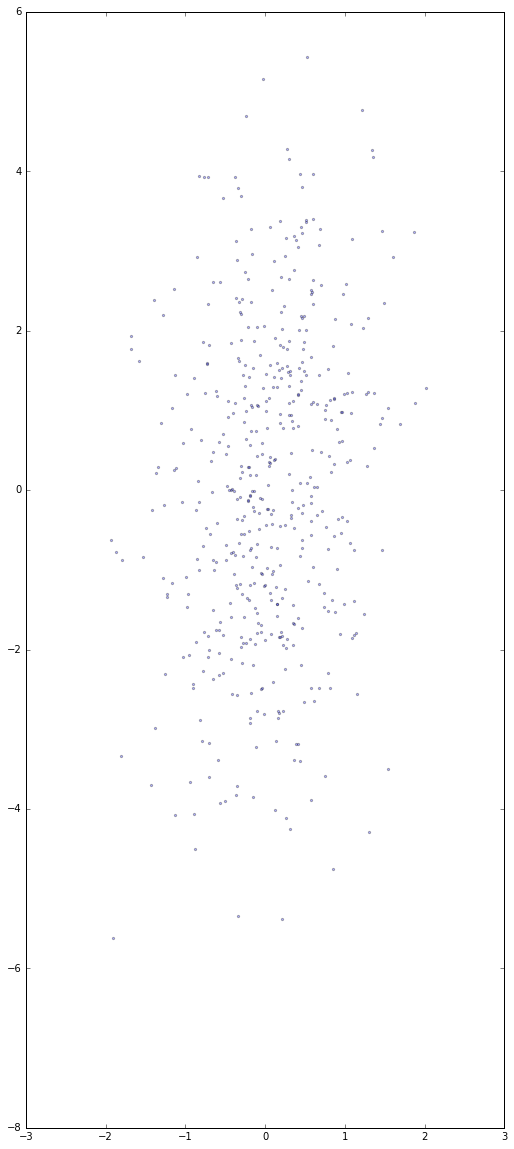

In [37]:
fig = plt.figure(0,figsize=[20,20])
ax = fig.add_subplot(111, aspect='equal')

plotcov(Cnew,'red',lw=1)
plotcov(C,'red')
Dnew = np.dot(np.linalg.inv(C),D)
plotcov(Dnew,'blue',lw=1)
plotcov(D,'blue')
print Cnew
print Dnew

evals,evecs = np.linalg.eig(Dnew)

index = np.argmax(evals)
eigenvalue = evals[index]
v1 = evecs[:,index]
v2 = np.zeros(len(Z))
v2[0] = 1
R = adjusted_rotate_in_subspace(np.array([v2,v1]).T)
print R
print np.linalg.det(R)
Drot = np.dot(R.transpose(),Dnew)
plotcov(Drot,'green')
print np.rad2deg(np.arccos(R[0,0]))
print np.rad2deg(-np.arcsin(R[0,1]))
ax.hlines(0,-6,6)

=====

In [215]:


index = np.argmax(ZE)
eigenvalue = ZE[index]
S = np.ones(len(Z))
S[0] = eigenvalue
S = np.diag(S)
v1 = ZV[:,index]
v2 = np.zeros(len(Z))
v2[0] = 1
R = adjusted_rotate_in_subspace(np.array([v2,v1]).T)
#F = np.dot(R.transpose(),np.dot(S,R))
#F = linalg.sqrtm(F)
#Mnew = np.dot(np.dot(np.linalg.inv(F),M),F)
Mnew = np.dot(R,np.dot(np.dot(S,Z),R.transpose()))

[ 2.62  1.15]


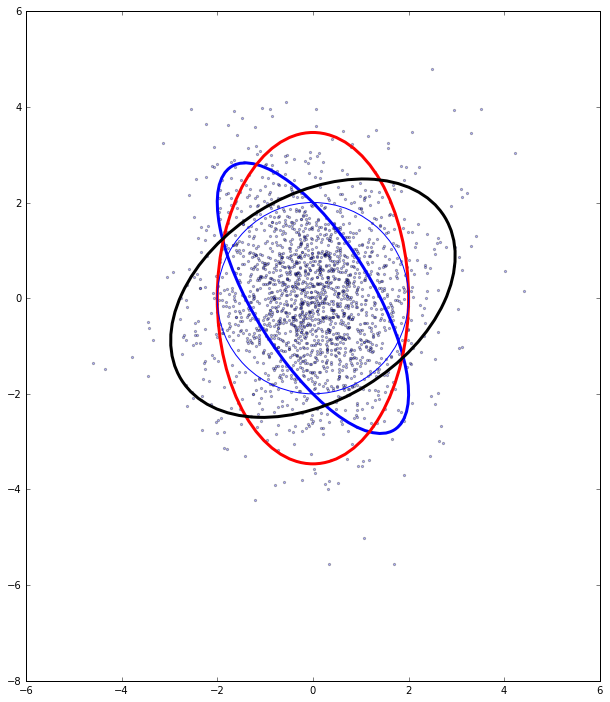

In [216]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib.patches import Ellipse
fig = plt.figure(0,figsize=[12,12])
ax = fig.add_subplot(111, aspect='equal')

def plotcov(ax,C,color='blue',lw=3):
    evals, evecs = np.linalg.eig(C)
    samps = np.random.multivariate_normal(np.zeros(2),C,500)
    ax.scatter(samps[:,0],samps[:,1],marker='.',alpha=0.3)
    ang = np.rad2deg(np.arctan2(evecs[1,0],evecs[0,0]))
    ax.add_artist(Ellipse(xy=[0,0], width=4*np.sqrt(evals[0]), height=4*np.sqrt(evals[1]), angle=ang, lw=lw, ec=color, fc='none'))

plotcov(ax,M)
#plotcov(ax,Mnew,'b',lw=1)
plotcov(ax,C,'r')
plotcov(ax,Z,'k')
plotcov(ax,np.eye(2),'b',lw=1)

In [134]:
np.linalg.eig(C)

(array([ 0.38,  2.62]), array([[-0.85, -0.53],
        [ 0.53, -0.85]]))

In [ ]:
np.linalg.eig(M)

Rather than all that hassle, why aren't we just using the orthonormal basis provided by the eigenvectors!

In [ ]:
#    while np.any(evals>1.0):
#        indices = np.real(evals)>1.0                
#        e = evects[:,indices][:,0] #we'll just do one...
#        v = evals[indices][0]      
#        Smat = np.eye(len(e))
#        Smat[0]*=v
#        cov = np.dot(evects,np.dot(Smat,np.dot(np.linalg.inv(evects),cov)))
#        #cov += newcov * 0.1        
#        evals,evects = np.linalg.eig(np.dot(np.linalg.inv(cov),newcov))
        